##Validation and Model Selection
Here look at _model evaluation_ and the tuning of _hyperparameters_, which are parameters that actually define the model 

In [6]:
from __future__ import print_function, division

In [7]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn

In [8]:
seaborn.set()

###Validating Models

Super key part of machine learning is model validation. Basically this is checking how well model fits a given dataset. Key things need to watch out for/be careful of!

E.G. our digits example! LEts take a look at this!



In [9]:
from sklearn.datasets import load_digits
digits = load_digits()
digitsX = digits.data
digitsY = digits.target

In [10]:
digitsXDF = pd.DataFrame(digitsX)
digitsYSeries = pd.Series(digitsY)

In [11]:
print('the shape of digitsXDF', digitsXDF.shape)
print('the shape of digitsYSeries', digitsYSeries.shape)

the shape of digitsXDF (1797, 64)
the shape of digitsYSeries (1797,)


Fitting a K-neighbors classifier

In [12]:
from sklearn.neighbors import KNeighborsClassifier
digitsKNN = KNeighborsClassifier(n_neighbors=1)

In [13]:
digitsKNN.fit(digitsXDF, digitsYSeries)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_neighbors=1, p=2, weights='uniform')

In [14]:
#Now use it to predict 
digitPredictions = digitsKNN.predict(digitsXDF)

In [15]:
#lets see how well we did
print("{0} / {1} correct".format(np.sum(digitsYSeries==digitPredictions), len(digitsYSeries)))

1797 / 1797 correct


This would suggest we have a perfect classifier....

### Validation Sets

Well we tested our data on the same set we trained on. This is obviously not a good idea. We are basically over-fitting our data and learning the noise. Instead we want to hold out a split of the dataset that wont be involved in our training

In [16]:
from sklearn.cross_validation import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(digitsXDF, digitsYSeries)

In [17]:
print('X train shape', X_train.shape)
print('X test shape', X_test.shape)

X train shape (1347, 64)
X test shape (450, 64)


Now train on the training data and validate on the test data

In [18]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, Y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_neighbors=1, p=2, weights='uniform')

In [19]:
yPred =  knn.predict(X_test)

In [20]:
print("{0} / {1}".format(np.sum(Y_test == yPred), len(Y_test)))

445 / 450


This is much more reliable estimate of how our model is actually doing

Our metric here is an called an **accuracy score**, it compares the number of matches to the total number of samples. It is computed using the following routine:

In [22]:
from sklearn.metrics import accuracy_score
accuracy_score(Y_test, yPred)

0.98888888888888893

Can also compute this directly from the model.score method

In [23]:
knn.score(X_test, Y_test)

0.98888888888888893

Using this we can now ask how this score changes as we change the tuning parameters in our model

In [26]:
for n_neighbors in [1,5,10, 20, 30]:
    knn = KNeighborsClassifier(n_neighbors)
    knn.fit(X_train, Y_train)
    print(n_neighbors, knn.score(X_test, Y_test))

1 0.988888888889
5 0.988888888889
10 0.977777777778
20 0.966666666667
30 0.966666666667


See here that a small number of neighbors seems to give us the best results!

###Cross-Validation

Problem with cross-validation is that we 'lose' some of our data. In above example we used 3/4 of data for training and 1/4 of the data for validation. Another option is to use **2-fold-cross-validation** where we split the sample in half and perform the validation twice:

In [28]:
X1, X2, Y1, Y2, = train_test_split(digitsXDF, digitsYSeries, test_size=0.5, random_state=0)

In [29]:
print('X1 shape', X1.shape)
print('X2 shape', X2.shape)

X1 shape (898, 64)
X2 shape (899, 64)


In [31]:
print(KNeighborsClassifier(1).fit(X2, Y2).score(X1, Y1))
print(KNeighborsClassifier(1).fit(X1, Y1).score(X2,Y2))

0.983296213808
0.982202447164


So here we see that a two-fold-cross-validation gives us two estimates of the score for that parameter.
skit-learn has an awesome utility for this

In [37]:
from sklearn.cross_validation import cross_val_score
cv = cross_val_score(KNeighborsClassifier(n_neighbors=1), digitsXDF, digitsYSeries, cv=2)
cv.mean()

0.96048785080069765

###K-Fold Cross Validation
Here used 2-fold cross validation. This is one specilizaiton of K-fold Cross Validation where we split the data into K chunks and perform K fits. Each chunk takes a turn at the validation set. Can do this by changing the cv parameter above. Hre is 10 fold cross validation: 

In [38]:
cross_val_score(KNeighborsClassifier(n_neighbors=1), digitsXDF, digitsYSeries, cv=10)

array([ 0.93513514,  0.99453552,  0.97237569,  0.98888889,  0.96089385,
        0.98882682,  0.99441341,  0.98876404,  0.97175141,  0.96590909])

10 fold cv gives us even better idea of how our model is doing. But gotta be careful with how much we are splitting our data.

###Overfitting, Underfitting and Model Selection

Basics of validation and cross-validation done. Now moving into even more depth regarding model selection. 

The issues assosciated with validation and cross_validation are some of the most important aspects of machine learning. Selecting optimal model for data is obviously model. Often underappreciated by machine learning peeps.

Following question is super important:
**If estimator is underperforming how should move foward**
- Use simpler or more complicated model?
- Add more features to each observed data point?
- Add more training samples?

Answer is often counter-intuitive. 

- Often using more complicated model gives worse results. 
- Sometimes adding training data wont improve results

Ability to determine what steps will improve model is what seperates the successful machine learnign from the novice. 

###Bias-Variance Tradeoff

Will be working with simple 1D Regression problem. Lets us easily visualize data and model. Easy generalize to higher dimensions. Explore **linear regression problem**. Can be accomplished with skitlearn skitlearn.linear_model

Lets make simple linear func we want to fit.

In [39]:
def test_func(x, err=0.5):
    y = 10 - 1. / (x+0.1)
    if err > 0:
        y = np.random.normal(y, err)
    return y

Make realization of dataset

In [40]:
def make_data(N=40, error=1.0, random_seed=1):
    #randomly sample data
    np.random.seed(1)
    X = np.random.random(N)[: , np.newaxis]
    Y = test_func(X.ravel(), error)
    
    return X, Y

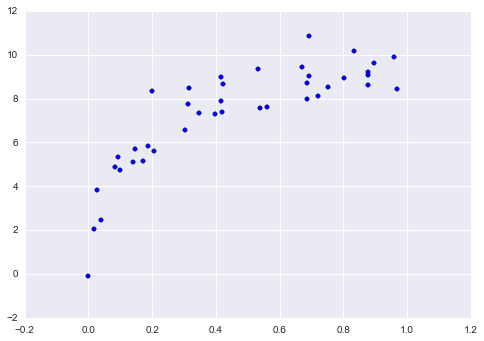

In [42]:
X, Y = make_data(40, error=1)
plt.scatter(X.ravel(), Y)

OK lets do some regression shit on this data. Build in linear regression function to compute the fit. 

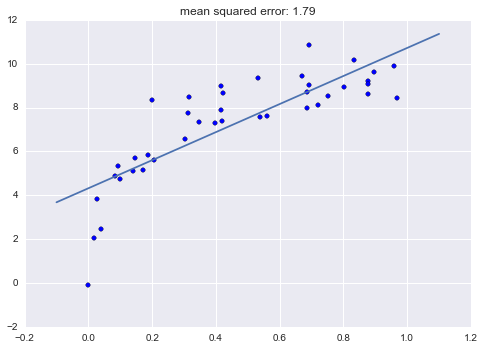

In [45]:
X_test = np.linspace(-0.1, 1.1, 500)[:, None]

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
model = LinearRegression()
model.fit(X,Y)
Y_test = model.predict(X_test)

plt.scatter(X.ravel(), Y)
plt.plot(X_test.ravel(), Y_test)
plt.title('mean squared error: {0:.3g}'.format(mean_squared_error(model.predict(X), Y)))

We have fit a straight line to the data, but clearly model not a good choice. The model here is **biased** or, that it **under-fits** the data.

Lets try to improve this by creating a more compliated model. Do this by adding degrees of freedom, and computing a polynomial regression over the inputs. Sckit-learn makes this easy with the PolynomialFeatures preprocessor, which can be pipelined with a linear regression.  

Make a convenience routine for this:


In [47]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree), LinearRegression(**kwargs))

Use this to fit quadratic curve to the data

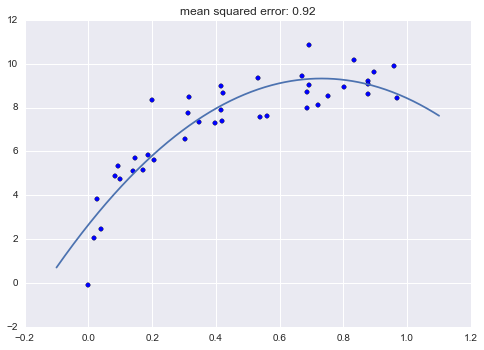

In [58]:
model = PolynomialRegression(2)
model.fit(X, Y)
Y_test = model.predict(X_test)

plt.scatter(X.ravel(), Y)
plt.plot(X_test.ravel(), Y_test)
plt.title("mean squared error: {0:.3g}".format(mean_squared_error(model.predict(X), Y)));

This polynomial regression has reduced the MSE and gives us a much better fit. What happens if we use a higher degree polynomial

(-4, 14)

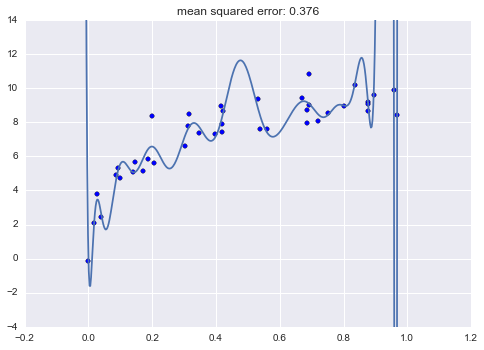

In [60]:
model = PolynomialRegression(30)
model.fit(X,Y)
Y_test = model.predict(X_test)

plt.scatter(X.ravel(), Y)
plt.plot(X_test.ravel(), Y_test)
plt.title('mean squared error: {0:.3g}'.format(mean_squared_error(model.predict(X), Y)))
plt.ylim(-4,14)

When increase degree to the extent, clear that resulting fit is no longer reflecting the true underlying distribution. Its actually more sensitive to the noise than the actual data. So we call it a **high variance model** and that it **over-fits** the data.

In [61]:
Use interact function to see the fit change

SyntaxError: invalid syntax (<ipython-input-61-220e5ec3cea5>, line 1)

In [65]:
from IPython.html.widgets import interact 

def plot_fit(degree=1, Npts=50):
    X, Y = make_data(Npts, error=1)
    X_test = np.linspace(-0.1, 1.1, 500)[: ,None]
    
    model = PolynomialRegression(degree=degree)
    model.fit(X,Y)
    Y_test = model.predict(X_test)
    
    plt.scatter(X.ravel(), Y)
    plt.plot(X_test.ravel(), Y_test)
    plt.ylim(-4, 14)
    plt.title('mean squared error: {0:.2f}'.format(mean_squared_error(model.predict(X), Y)))

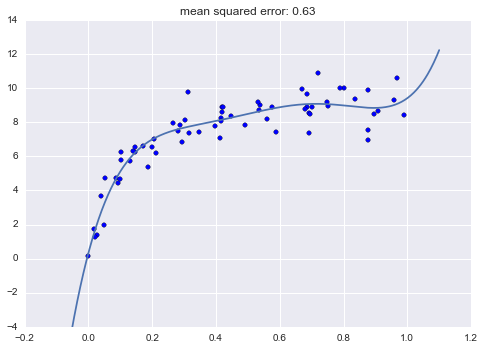

In [66]:
interact(plot_fit, degree=[1, 30], Npts=[2,100])

###Detecting Over-Fitting with Validation Curves
Clearly, computing the error on training data is not enough. Instead we can use **cross-validation** to get a better handle on how the model fit is working.

Will do this here again using validation_curve utility. Make things more clear by using slightly larger dataset:

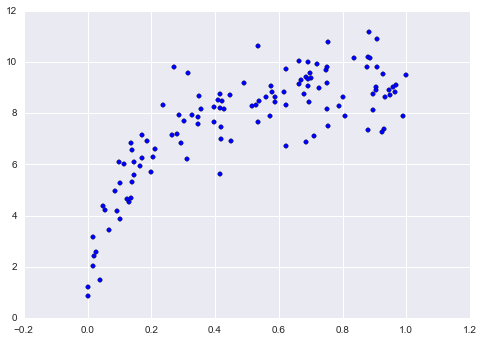

In [67]:
X,Y = make_data(120, error=1.0)
plt.scatter(X,Y)

In [72]:
from sklearn.learning_curve import validation_curve

def rms_error(model, X, y):
    y_pred = model.predict(X)
    return np.sqrt(np.mean((y - y_pred) ** 2))

degree = np.arange(0, 18)
val_train, val_test = validation_curve(PolynomialRegression(), X, Y,
                                       'polynomialfeatures__degree', degree, cv=7,
                                       scoring=rms_error)

Plot validation curves

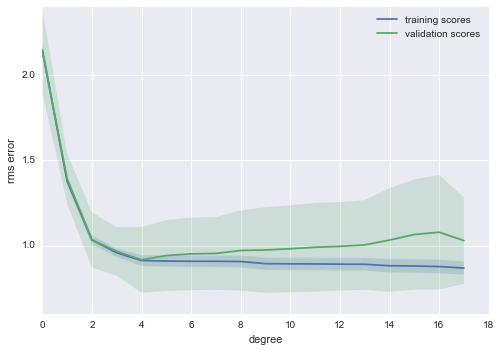

In [73]:
def plot_with_err(x, data, **kwargs):
    mu, std= data.mean(1), data.std(1)
    lines = plt.plot(x, mu, '-', **kwargs)
    plt.fill_between(x, mu - std, mu + std, edgecolor='none', facecolor=lines[0].get_color(), alpha=0.2)
    
plot_with_err(degree, val_train, label='training scores')
plot_with_err(degree, val_test, label='validation scores')
plt.xlabel('degree')
plt.ylabel('rms error')
plt.legend()

    

Notice trend which is common for this type of plot:
- For small model complexity training and validation error very similar. This shows that model is **under-fitting** the data: doesn't have enough complexity to represent the data. **high-bias** model
- As model grows in complexity training and validation scores diverge. Indicates the the model is now **over-fitting** the data: has so much flexibility that it fits the noise rather than underlying trend. **high-variance** model. 
- Note training scores nearly always improves with additional complexity. This is because more complicated models fit the noise much better. Validation data generally has a sweet spot. Here thtas at about a degree of 5. 

Lets look at our best-fitting model according to the cross-validation

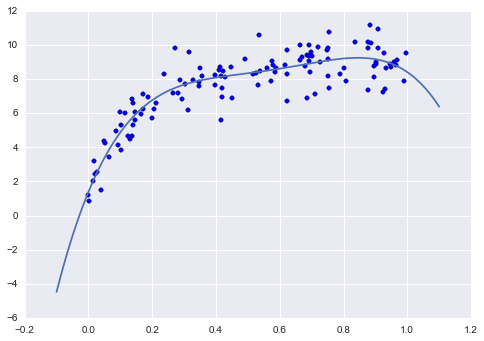

In [75]:
model = PolynomialRegression(4).fit(X, Y)
plt.scatter(X, Y)
plt.plot(X_test, model.predict(X_test))

###Detecting Data Sufficiently With Learning Curves
The exact turning point of the trade-off between bias and variance is highly dependent on the number of trianing points we use. Show this via _learning curves_. Learning curves will display this property

Key idea is to plot the MSE for the training and test set as a function of the _Number of Training Points_

In [83]:
from sklearn.learning_curve import learning_curve

def plot_learning_curv(degree=3):
    train_sizes = np.linspace(0.05, 1, 20)
    N_train, val_train, val_test = learning_curve(PolynomialRegression(degree), X, Y, train_sizes, cv=5, scoring=rms_error)
    plot_with_err(N_train, val_train, label='training scores')
    plot_with_err(N_train, val_test, label='validation scores')
    plt.xlabel('Training set sizes')
    plt.ylabel('rms error')
    plt.ylim(0, 3)
    plt.xlim(5, 80)
    plt.legend()

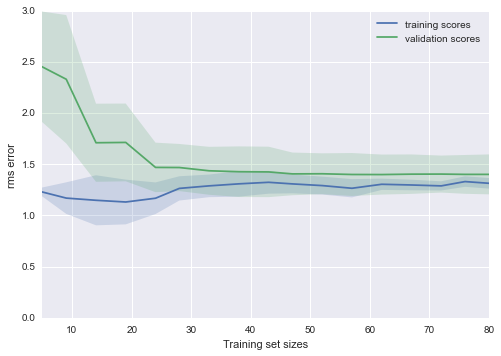

In [84]:
plot_learning_curv(1)

Here have a typical learning curve. At very small number of training points there is a huge seperation between the training and test error. This clearly indicates **overfitting**. But for the same model with a large number of training points the training and test errors converge. This points to potential **underfitting**.

As we add more data points beyond this point the training error will never increase and the testing error will never decease (I think this is because we will continually underfit the data since we aren't using a complez enough model. We simply arent' capturing the true relationship).

In this plot we can see that if we would like to reduce the MSE down to the nominal value of (1.0) which is magnitude of the scatter we put in when constructing the data, then adding more samples will _never_ actually get us there. For d=1 the two curves have converged and cant move lower. What about for larger d value though?  

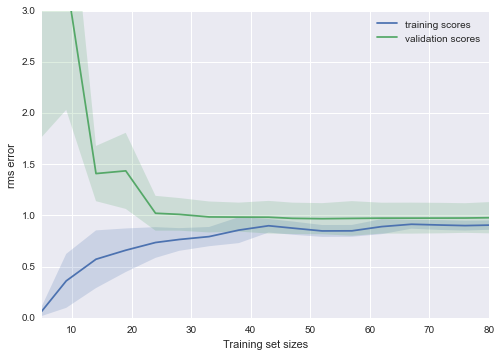

In [87]:
plot_learning_curv(3)

By adding more model complexity managed to lower the level of convergence to an rms error of 1.0!

Lets get even more complex up in this ish

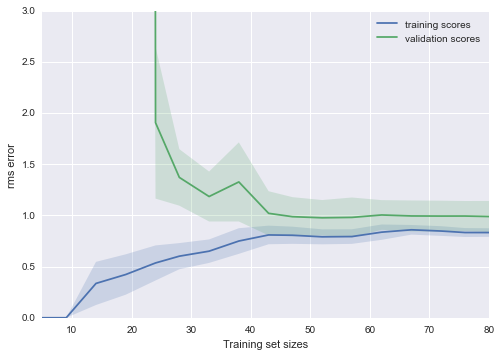

In [88]:
plot_learning_curv(10)

So here we converge for an even more complex we converge still but we need a hell of alot more training data.

We see the following overall:

- Can cause the lines to converge by adding more points OR simplifying the model
- can bring the convergence error down only by decreasing the complexity of the model

So these curves can give us awesome hints about how we might improve a sub-optimal model we are using. If the curves are already close together then we need more model complexity. If the curves are far apart we could improve the model by adding more data.

Will make this more concrete: imagine telescope data where results aren't robust enough. Need to think about whether we spend the telescope time we have observing _more objects_ to get larger training data set or _more attributes of each object_ in order to improve the model. Answer to this question is super important and we can answer it by using metrics like these.

##Summary

Saw several awesome tools for model validation:
- **Training Score** shows how well model fits the data it was trained on. Not a good indification of model effectiveness
- **Validation Score** shows how well a model fits hold-out data. Most effective method is a form of cross_validation where multiple hold-out sets used
- **Validation Curves** are a plot of validation scores and training scores as function of **model complexity**:
    - When the two curves are close indicates _underfitting_
    - When the two curves are close it indicates _overfitting_
    - Sweet spot is in the _middle_
- **Learning Curves** are a plot of the validation score and training score as a function of **Number of training Points**
    - When curves are close indicates _underfitting_ and adding more data probs wont improve our estimator
    - When curves far apart indicates _overfitting_ and adding more data may increase model effectiveness

These tools are really awesome ways of evaluating our model on our data